Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [336]:
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from itertools import accumulate
from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [337]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 200
DENSITY = 0.1

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [338]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.power(SETS.sum(axis=1), 1.1)

In [339]:
SETS

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## Helper Functions

In [340]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [341]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(398808.2323058776))

In [342]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(197497.54783711454))

## Improved RHMC

In [343]:

def multiple_mutation_strenght(solution: np.ndarray, strenght: float = 0.3) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strenght
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    new_sol = np.logical_xor(solution, mask)
    return new_sol
    

In [344]:
#Fitness functioon

def fitness(solution: np.ndarray) :
    return (valid(solution), -cost(solution))

ic| fitness(solution): (np.True_, np.float64(-398808.2323058776))
ic| fitness(solution): (np.True_, np.float64(-160741.17245552636))


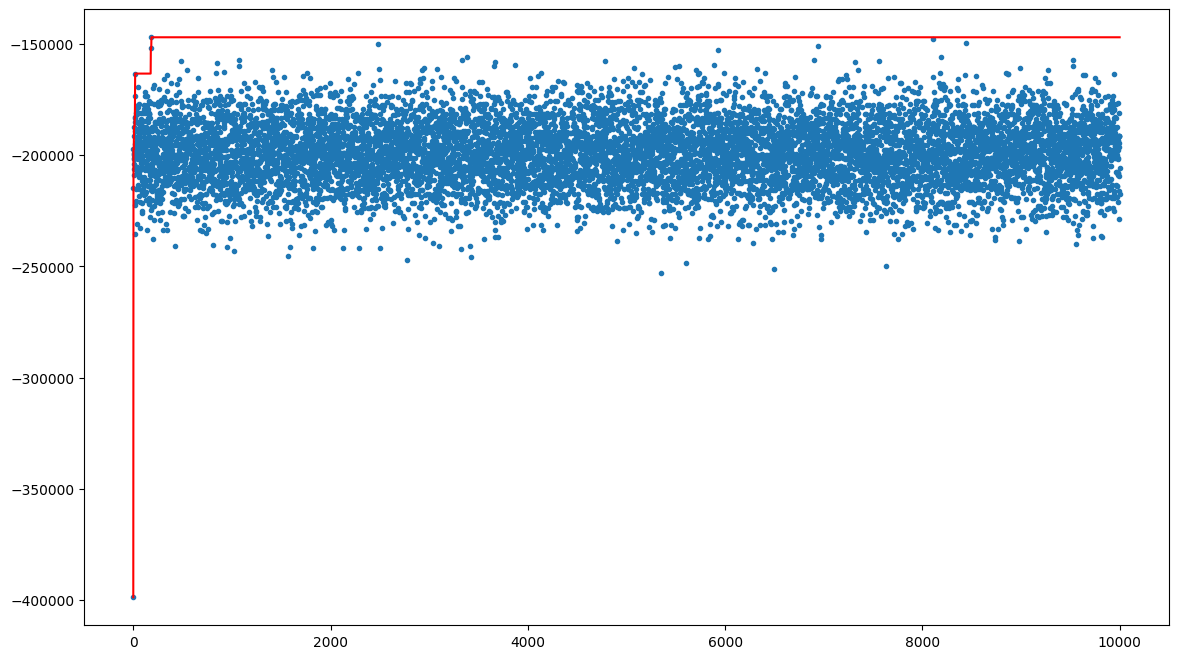

In [345]:
#Hill Climber function 

BUFFER_SIZE = 5 #rue of one out of five

solution = rng.random(NUM_SETS) < 1 #if less than ..., vector of all true?
solution_fitness = fitness(solution)
history = [float(solution_fitness[1])]
ic(fitness(solution))

# "Simulated Annhealing" try -> working, look ES
strength = 0.5
buffer = list()

for steps in range (10_000):
    new_solution = multiple_mutation_strenght(solution, strength)
    f = fitness(new_solution)

    history.append(float(f[1]))
    buffer.append(f > solution_fitness)
    buffer = buffer[-BUFFER_SIZE:] 

    if sum(buffer) > 10 : #change to 1/5 rule
        strength *= 1.1

    elif sum(buffer) == 10 :
        strength /= 1.1

    if f > solution_fitness :
        solution = new_solution
        solution_fitness = fitness(solution)
        #ic(fitness(solution))

#ic(solution)
ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")